#  **Import Modules**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.autolayout'] = True


import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D,Input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Load The Dataset**

In [3]:
BASE_DIR = '../input/utkface-new/UTKFace'

In [4]:
# Labels: age,gender and ethinicity

image_paths = []
age_labels = []
gender_labels = []


for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR,filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender =  int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
# Convert to Data Frame

df = pd.DataFrame()
df['image'],df['age'],df['gender'] = image_paths,age_labels,gender_labels
df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1


In [6]:
# Map Labels For Gender

gender_dict = {0:'Male',1:'Female'}

# **Exploratory Data Analysis**

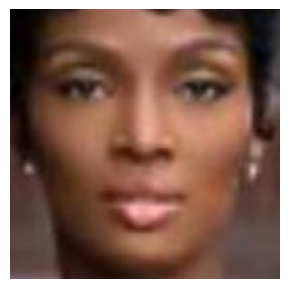

In [7]:
from PIL import Image
img = Image.open(df['image'][1])
plt.figure(figsize=(5,3))  
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

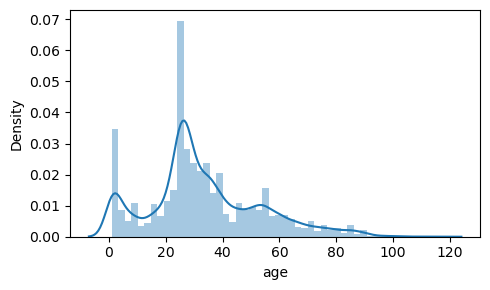

In [8]:
plt.figure(figsize=(5,3))  
sns.distplot(df['age'])

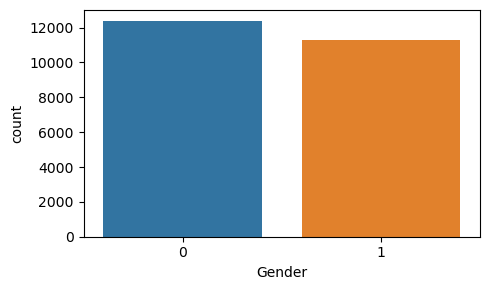

In [9]:
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='gender')
plt.xlabel('Gender')
plt.show()

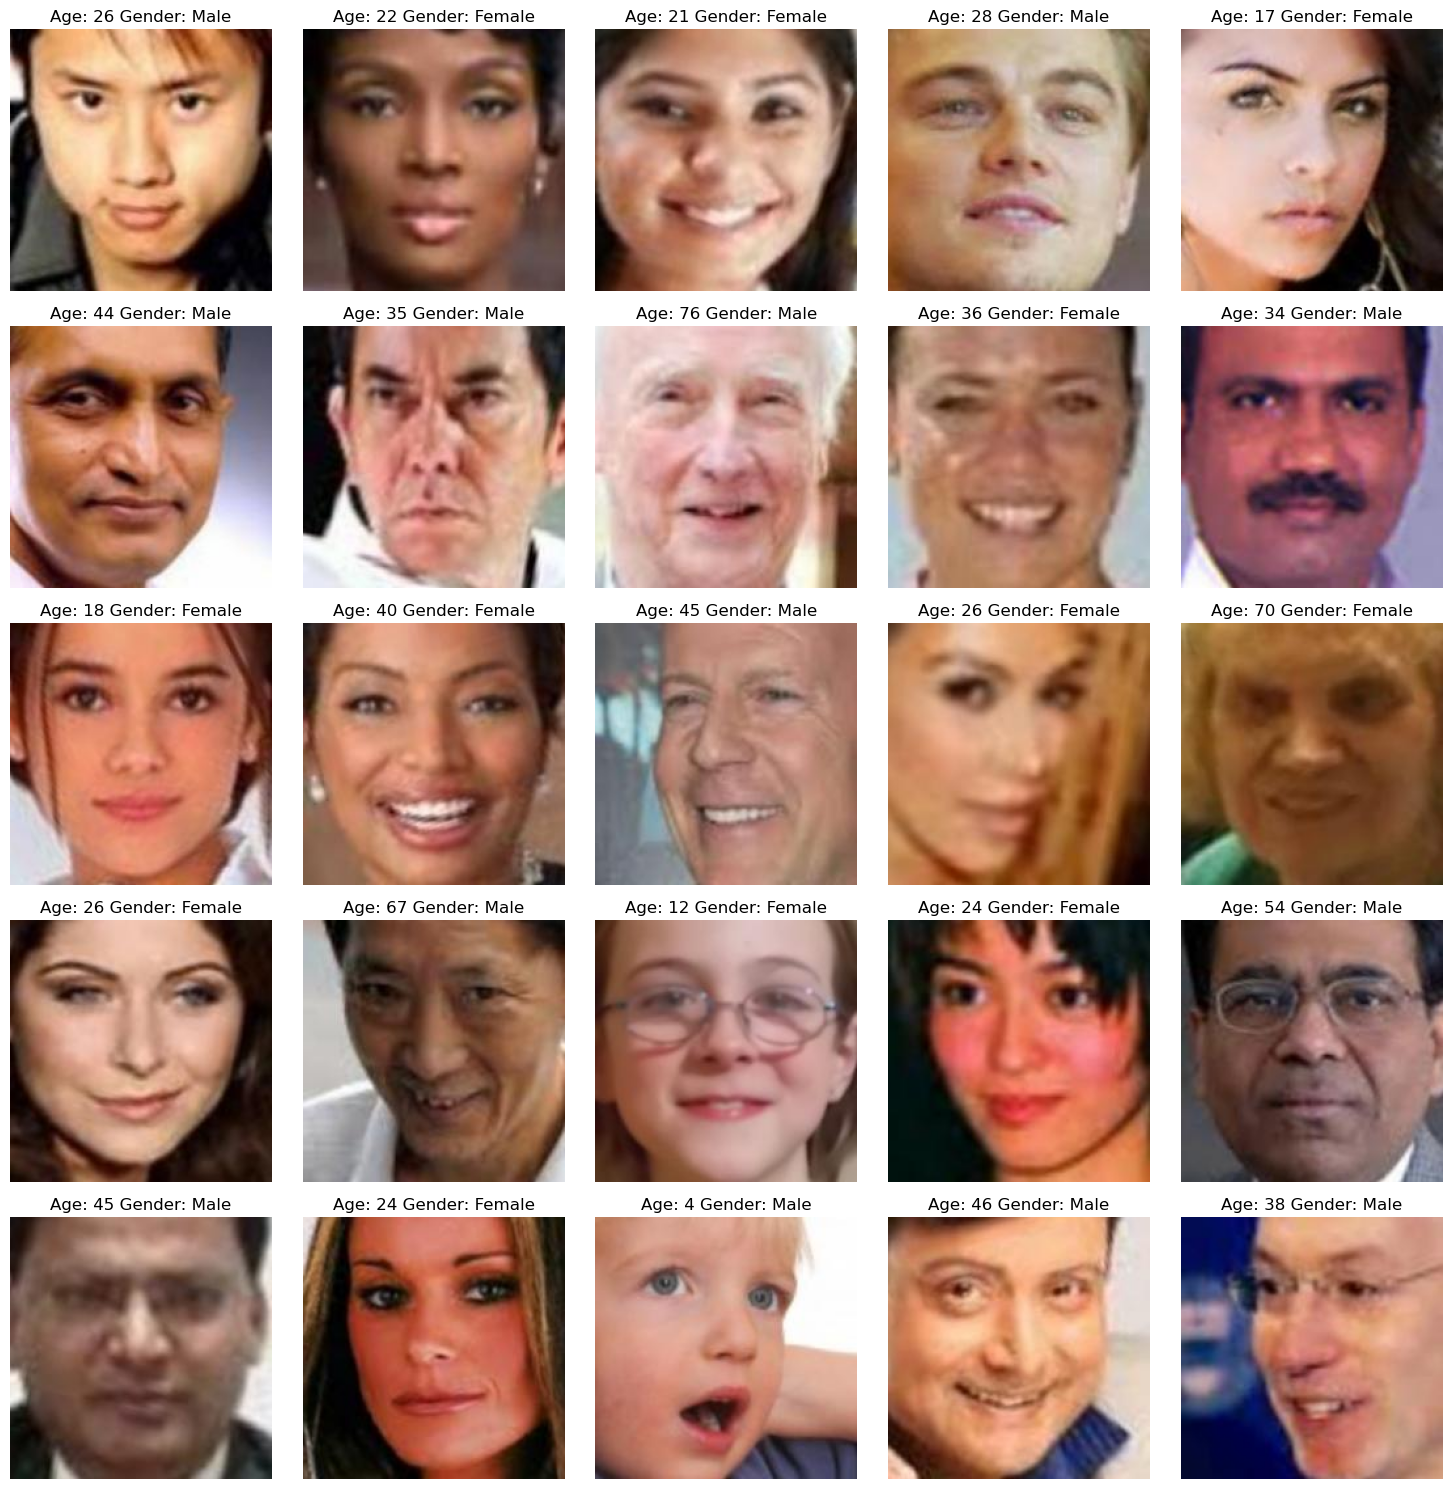

In [10]:
# To display grid of images
plt.figure(figsize=(15,15))
files = df.iloc[0:25]

for index,file,age,gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

# **Feature Extraction**

In [11]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,grayscale=True)
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    
    features = np.array(features)
    features = features.reshape(len(features),128,128,1)
    return features

In [12]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
X.shape

(23708, 128, 128, 1)

In [14]:
# Normalize The Images

X = X/255.0    # As image pixel values lie in range 0 - 255 we divide it by 255.0 to get all the image values in 0 - 1 range.


In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128,128,1)

# **Model Creation**

In [17]:
inputs = Input((input_shape))

# Convolutional Layers 
conv_1 = Conv2D(32,kernel_size=(3,3),activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64,kernel_size=(3,3),activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128,kernel_size=(3,3),activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(256,kernel_size=(3,3),activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten()(maxp_4)

# Fully Connected Layers (Dense Layers)

dense_1 = Dense(256,activation='relu')(flatten)
dense_2 = Dense(256,activation='relu')(flatten)

# Dropout Layers

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)


# Output Layers

output_1 = Dense(1,activation='sigmoid',name='gender_out')(dropout_1)
output_2 = Dense(1,activation='relu',name='age_out')(dropout_2)

model = Model(inputs=[inputs],outputs = [output_1,output_2])

model.compile(loss=['binary_crossentropy','mae'],optimizer='adam',metrics=['accuracy'])

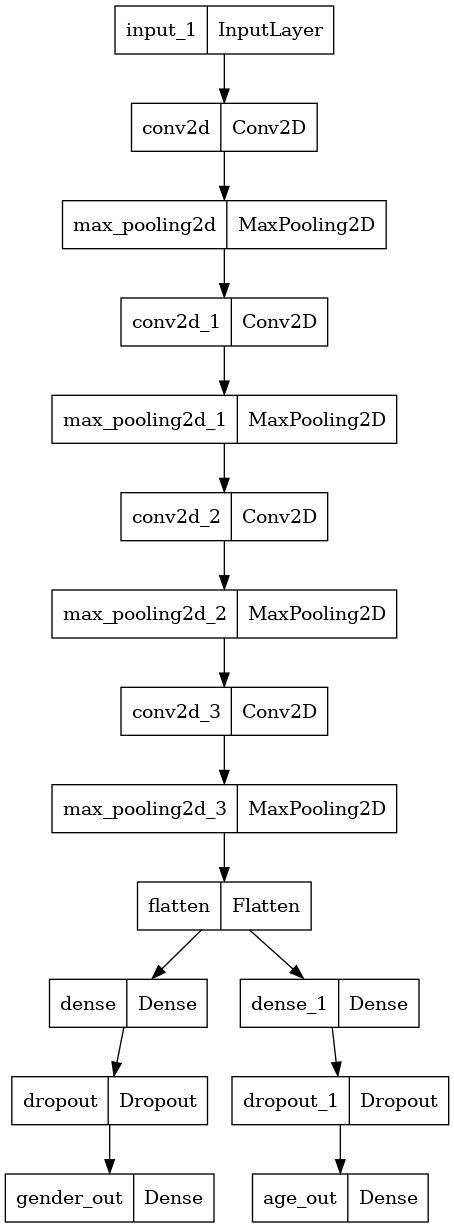

In [18]:
# Plot the Model

from tensorflow.keras.utils import plot_model
plot_model(model)

# **Train Model**

In [19]:
history = model.fit(x=X,y=[y_gender,y_age],batch_size=32,epochs=20,validation_split=0.2)

Epoch 1/20
593/593 [==============================] - 425s 713ms/step - loss: 15.8257 - gender_out_loss: 0.6844 - age_out_loss: 15.1413 - gender_out_accuracy: 0.5573 - age_out_accuracy: 0.0476 - val_loss: 13.3652 - val_gender_out_loss: 0.5420 - val_age_out_loss: 12.8232 - val_gender_out_accuracy: 0.7311 - val_age_out_accuracy: 0.0439
Epoch 2/20
593/593 [==============================] - 420s 708ms/step - loss: 11.8042 - gender_out_loss: 0.4894 - age_out_loss: 11.3149 - gender_out_accuracy: 0.7634 - age_out_accuracy: 0.0339 - val_loss: 10.6300 - val_gender_out_loss: 0.4185 - val_age_out_loss: 10.2115 - val_gender_out_accuracy: 0.8070 - val_age_out_accuracy: 0.0224
Epoch 3/20
593/593 [==============================] - 405s 683ms/step - loss: 10.0618 - gender_out_loss: 0.4170 - age_out_loss: 9.6449 - gender_out_accuracy: 0.8057 - age_out_accuracy: 0.0181 - val_loss: 8.6889 - val_gender_out_loss: 0.3769 - val_age_out_loss: 8.3120 - val_gender_out_accuracy: 0.8319 - val_age_out_accuracy: 0.

# **Plot The Results**

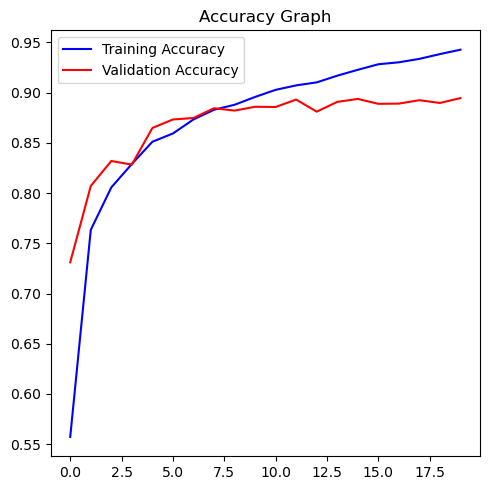

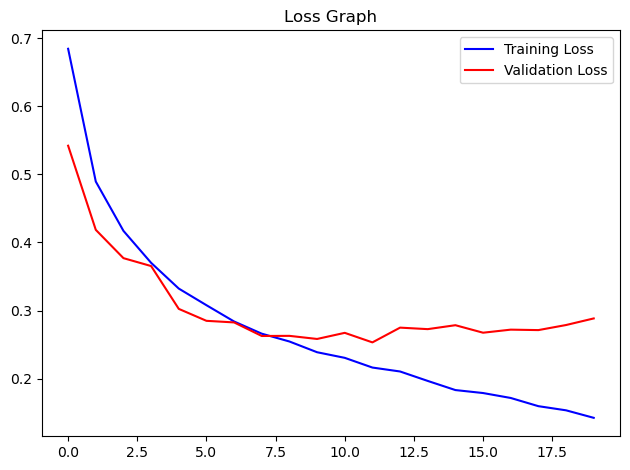

In [23]:
# Plot Results For Gender
plt.figure(figsize=(5,5))
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()


loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

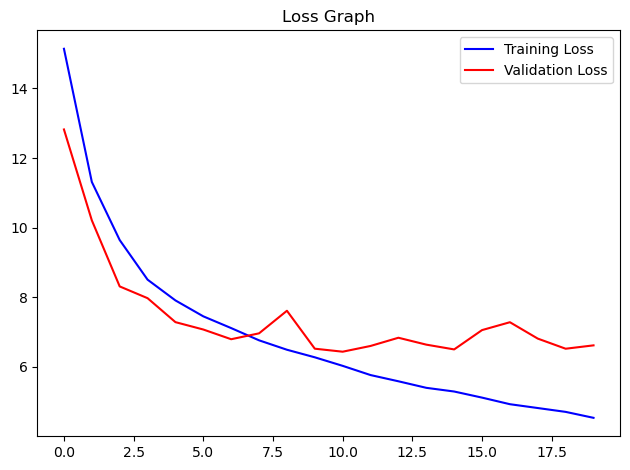

In [24]:
# Plot Results for Age 

loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# **Prediction With Test Data**

Enter Image Index You want to Test the Model:  3000


Original Gender: Male Original Age: 28
1/1 [==============================] - 0s 31ms/step

Predicted Gender: Male  Predicted Age: 28


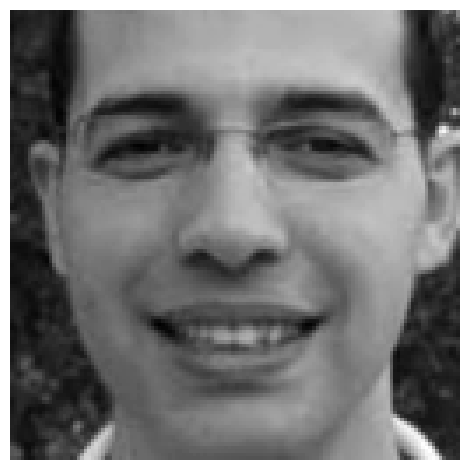

In [32]:
image_index = int(input('Enter Image Index You want to Test the Model: '))
print('Original Gender:',gender_dict[y_gender[image_index]], "Original Age: ",y_age[image_index])
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("\nPredicted Gender:",pred_gender," Predicted Age:",pred_age)
plt.imshow(X[image_index].reshape(128,128),cmap ='gray');
plt.axis('off');